# Random Forests - Heart Failure Dataset
## K-Fold Cross Validation
_The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree._

## Original Dataset

### Random Forests

In [1]:
# Load Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import ds_functions as ds
from sklearn.model_selection import KFold, cross_val_score

In [2]:
data: pd.DataFrame = pd.read_csv('../../datasets/heart_failure_clinical_records_dataset.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp
    
N_SPLITS = 10

<Figure size 600x450 with 0 Axes>

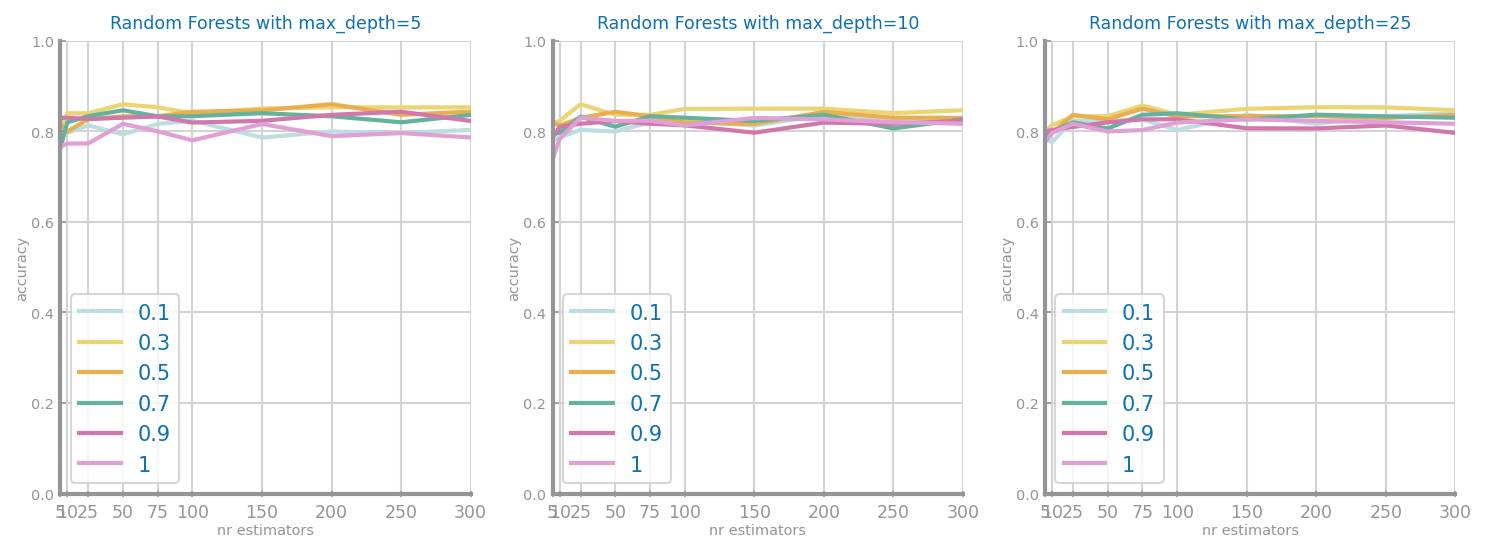

Best results with depth=5, 0.50 features and 200 estimators, with accuracy=0.86


In [3]:
kf = KFold(n_splits = N_SPLITS, shuffle=True)

max_depths = [5, 10, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

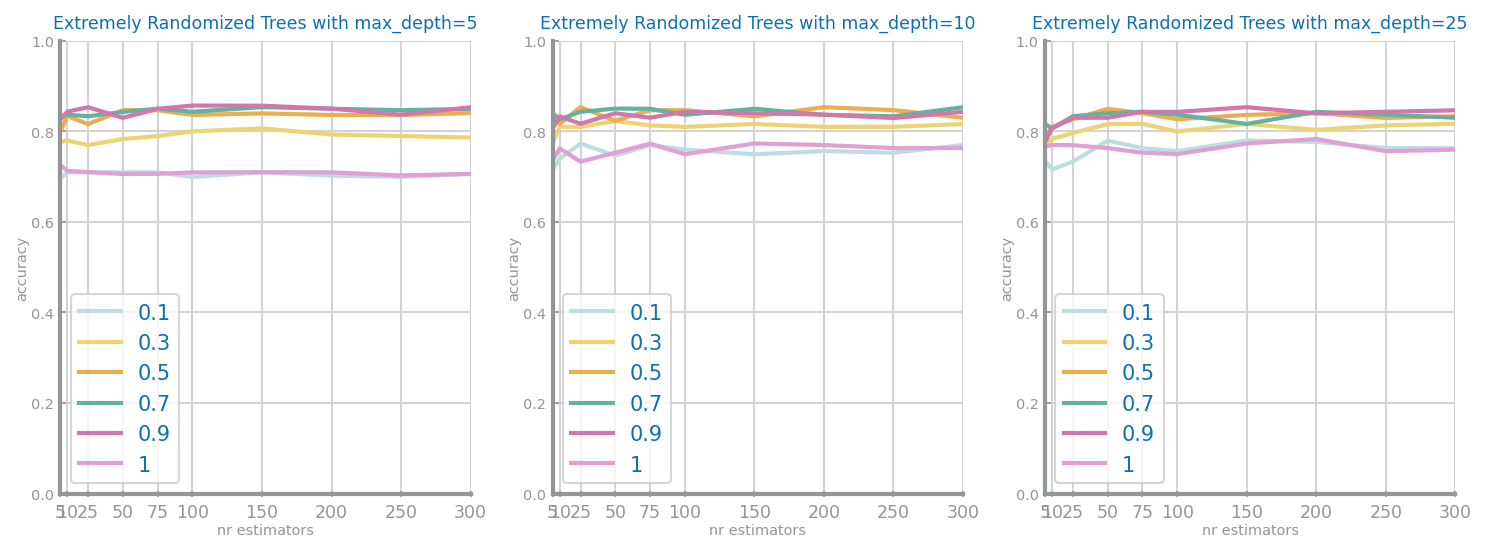

Best results with depth=5, 0.90 features and 100 estimators, with accuracy=0.86


In [4]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [5]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.95, 0.85]), 'Recall': array([0.86, 0.69]), 'Specificity': array([0.99, 0.92]), 'Precision': array([0.97, 0.8 ])}

Extremely Random Trees:
 {'Accuracy': array([0.91, 0.85]), 'Recall': array([0.78, 0.66]), 'Specificity': array([0.97, 0.94]), 'Precision': array([0.94, 0.83])}


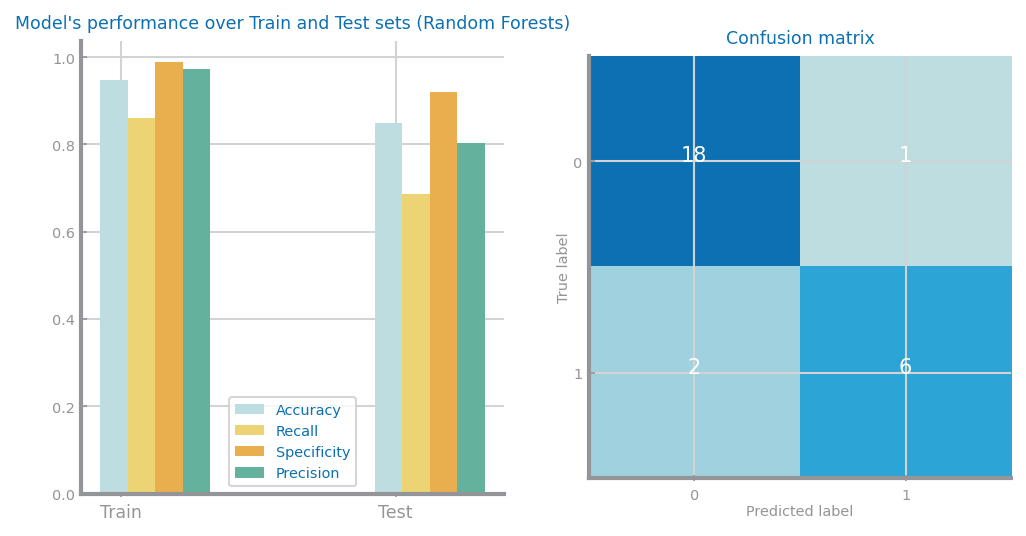

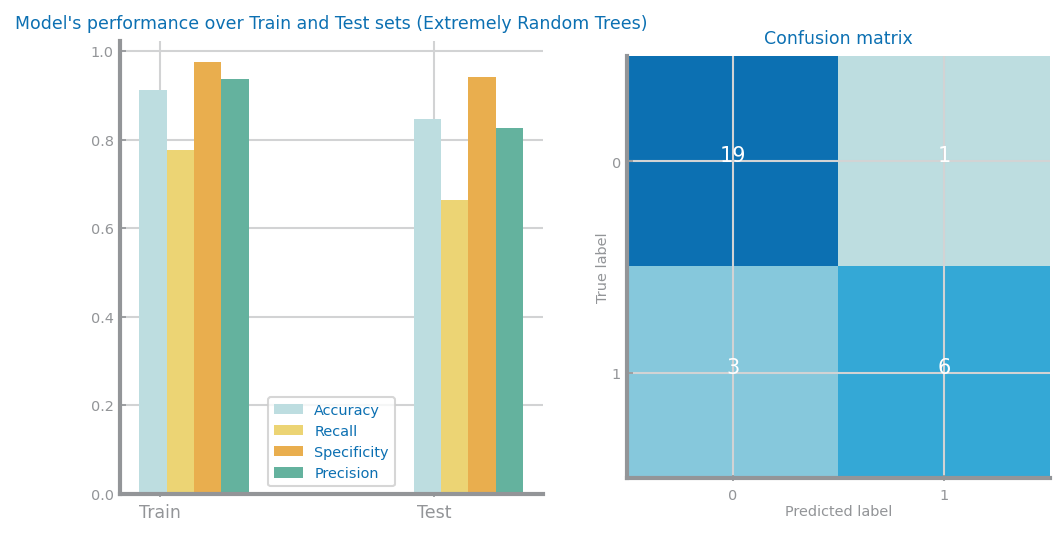

In [6]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    et = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    et.fit(trnX, trnY)
    
    prd_trn = et.predict(trnX)
    prd_tst = et.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

## Scaled Dataset (Standardized)

### Random Forests

In [7]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_scaled/HF_standardized.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp
    
N_SPLITS = 10

<Figure size 600x450 with 0 Axes>

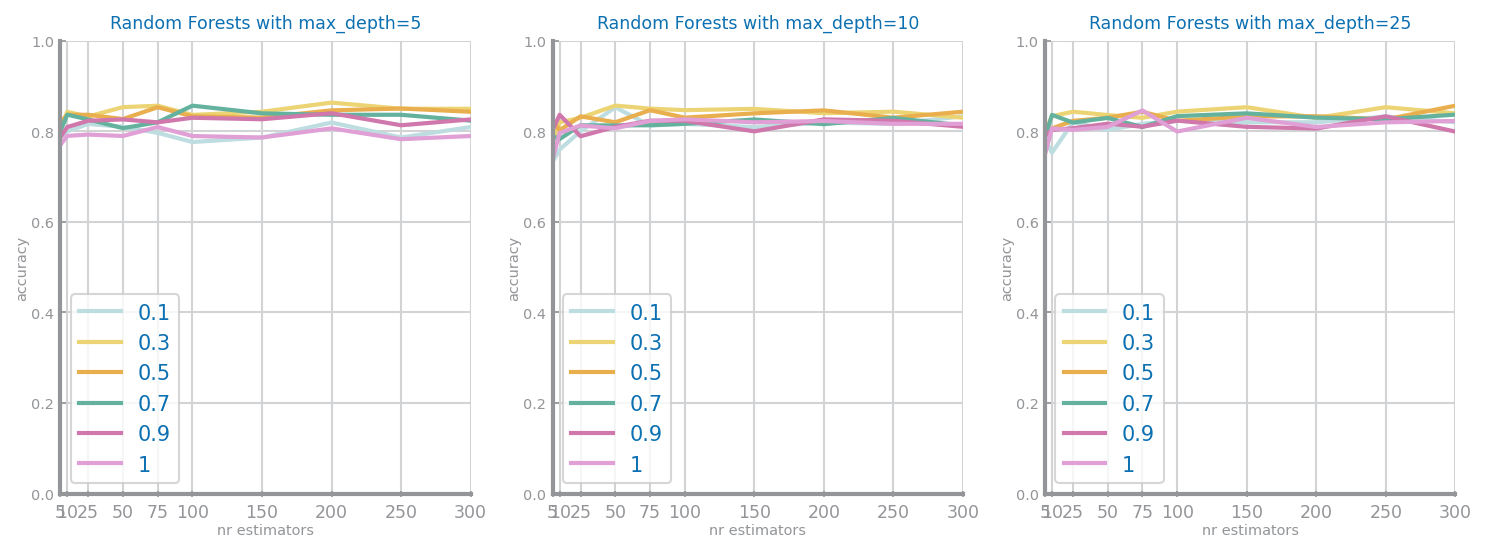

Best results with depth=5, 0.30 features and 200 estimators, with accuracy=0.86


In [8]:
kf = KFold(n_splits = N_SPLITS, shuffle=True)

max_depths = [5, 10, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

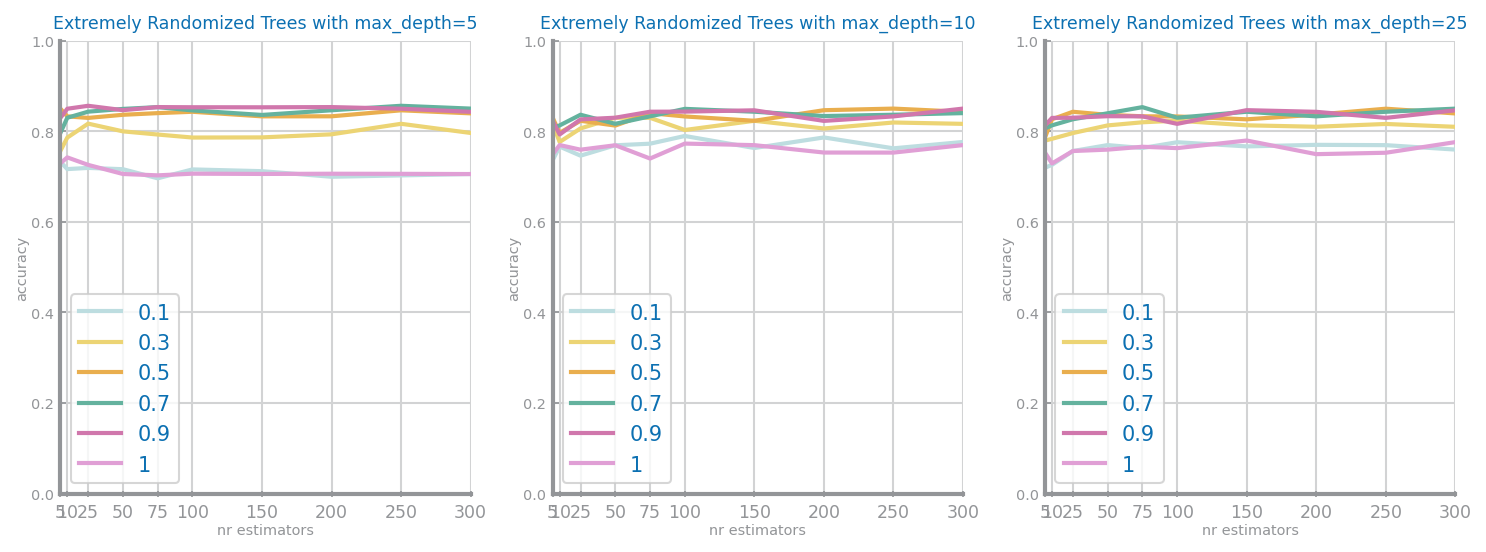

Best results with depth=5, 0.70 features and 250 estimators, with accuracy=0.86


In [9]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [10]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([0.94, 0.84]), 'Recall': array([0.84, 0.65]), 'Specificity': array([0.99, 0.93]), 'Precision': array([0.97, 0.8 ])}

Extremely Random Trees:
 {'Accuracy': array([0.91, 0.85]), 'Recall': array([0.75, 0.62]), 'Specificity': array([0.98, 0.95]), 'Precision': array([0.94, 0.86])}


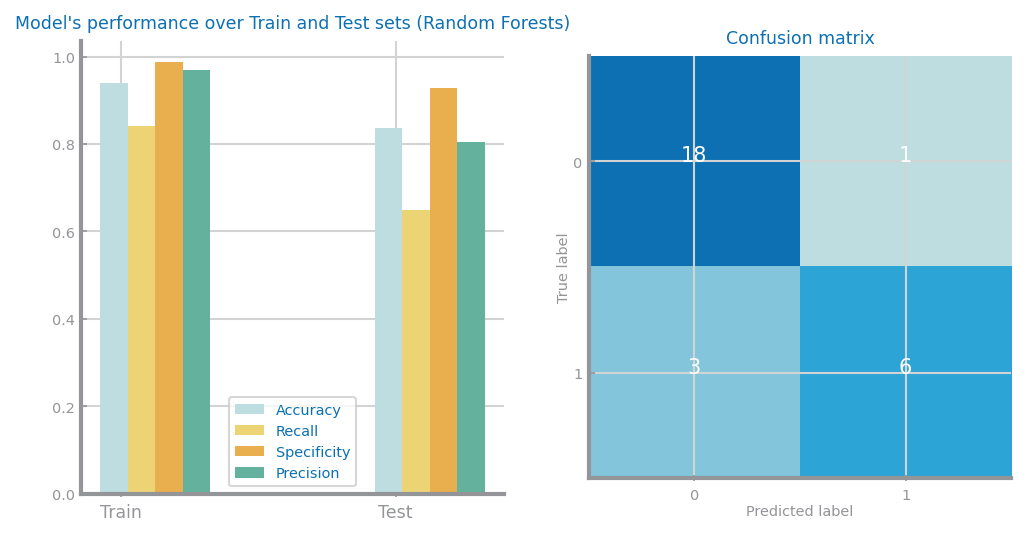

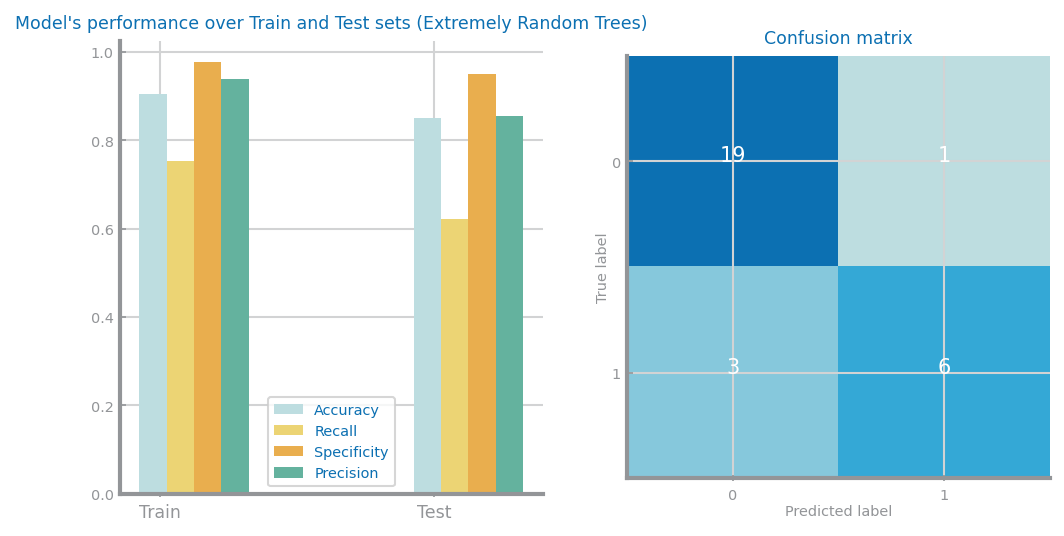

In [11]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    et = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    et.fit(trnX, trnY)
    
    prd_trn = et.predict(trnX)
    prd_tst = et.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

## Scaled & Outliers with Windsorization

### Random Forests

In [12]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierWins.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp
    
N_SPLITS = 10

<Figure size 600x450 with 0 Axes>

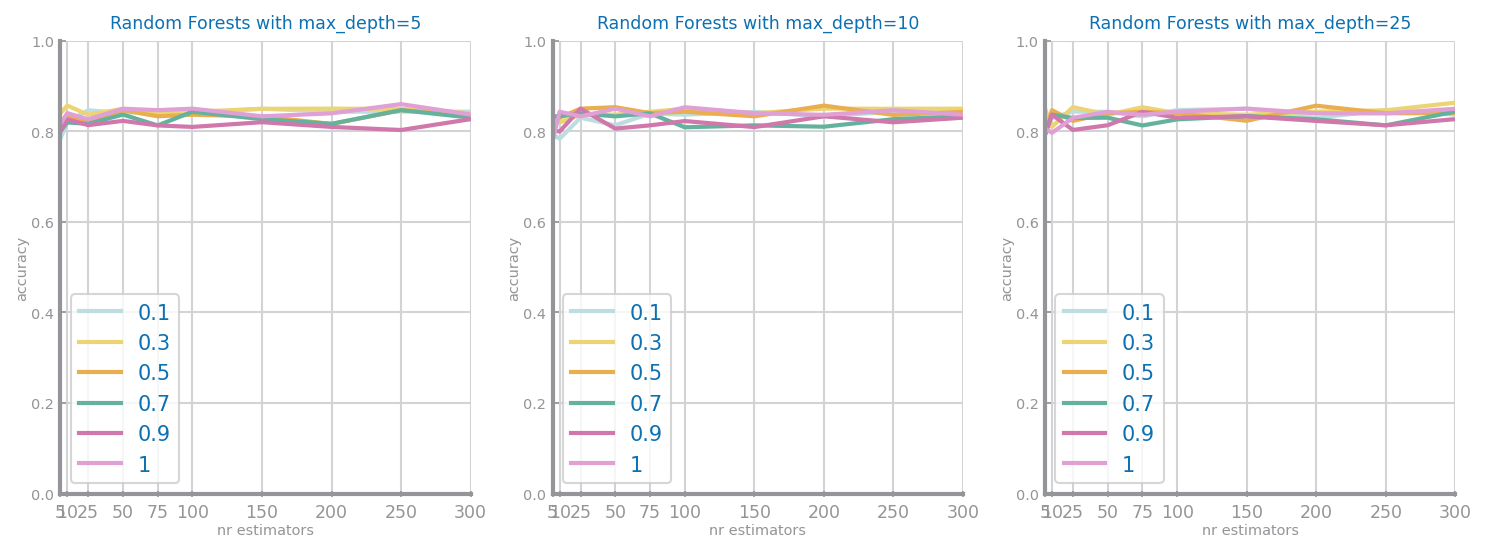

Best results with depth=25, 0.30 features and 300 estimators, with accuracy=0.86


In [13]:
kf = KFold(n_splits = N_SPLITS, shuffle=True)

max_depths = [5, 10, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

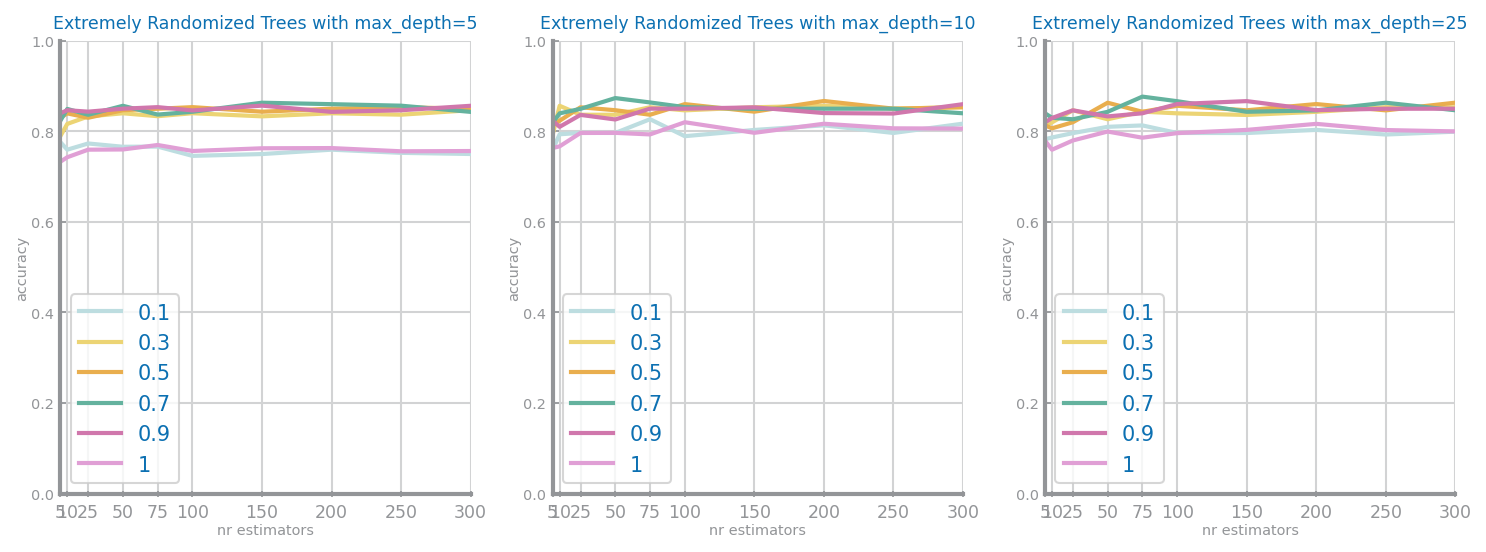

Best results with depth=25, 0.70 features and 75 estimators, with accuracy=0.88


In [14]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [15]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([1.  , 0.84]), 'Recall': array([1.  , 0.68]), 'Specificity': array([1.  , 0.92]), 'Precision': array([1. , 0.8])}

Extremely Random Trees:
 {'Accuracy': array([1.  , 0.85]), 'Recall': array([1. , 0.7]), 'Specificity': array([1.  , 0.93]), 'Precision': array([1. , 0.8])}


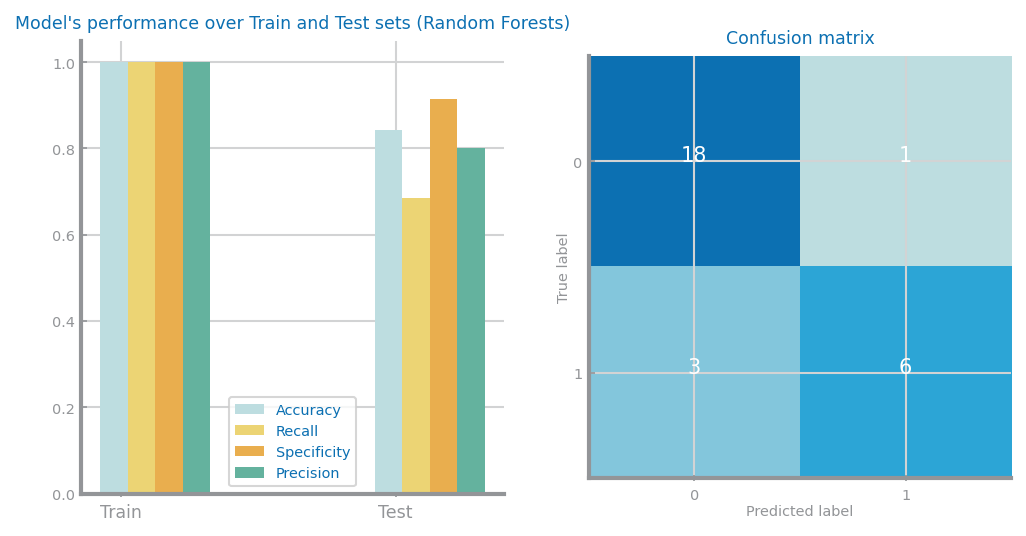

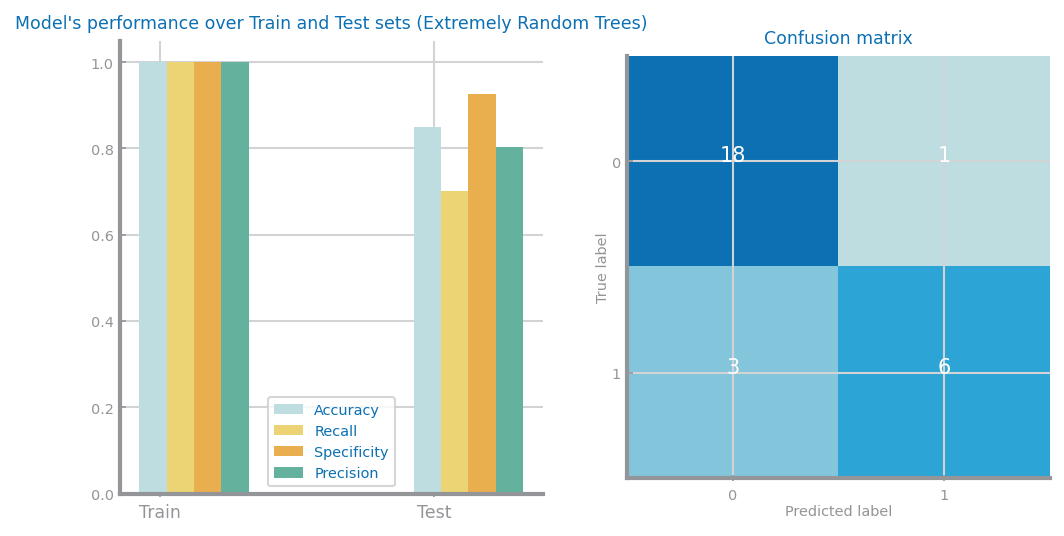

In [16]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    et = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    et.fit(trnX, trnY)
    
    prd_trn = et.predict(trnX)
    prd_tst = et.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)

## Trimmed Outliers Dataset (Interquartile)

### Random Forests

In [17]:
data: pd.DataFrame = pd.read_csv('../../datasets/hf_outliers/HR_S_outlierTrim_IQS.csv')
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels = pd.unique(y)
if(labels[0] == 1):
    temp = labels[0]
    labels[0] = labels[1]
    labels[1] = temp
    
N_SPLITS = 10

<Figure size 600x450 with 0 Axes>

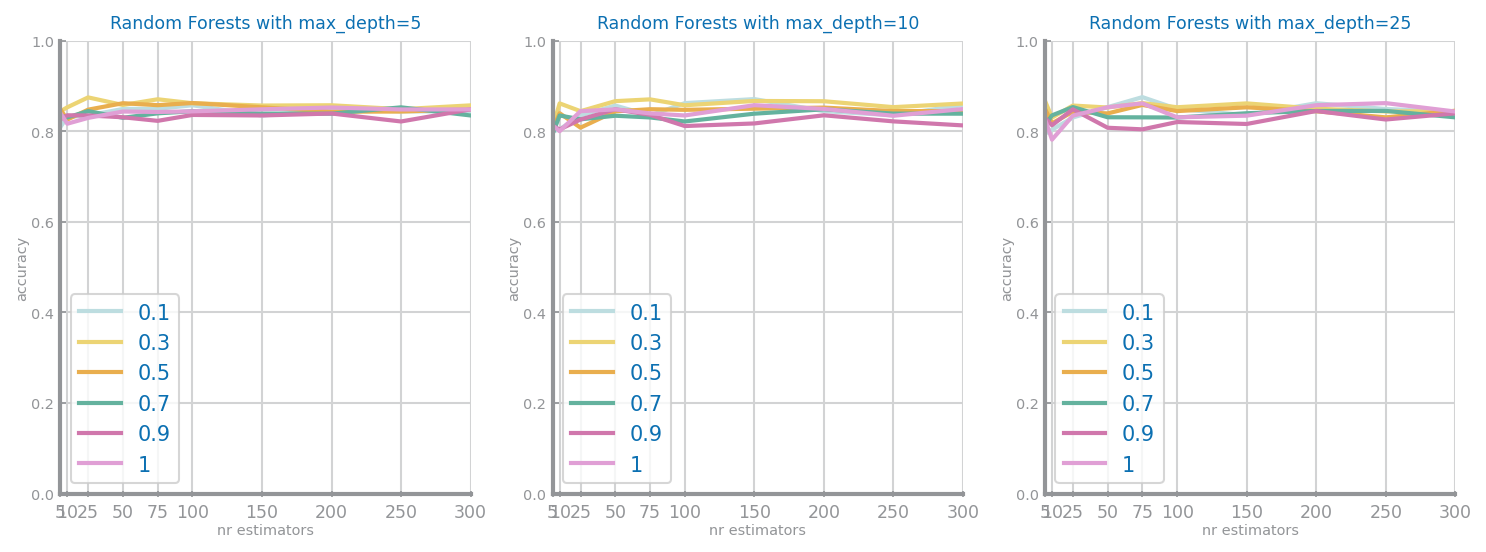

Best results with depth=25, 0.10 features and 75 estimators, with accuracy=0.88


In [18]:
kf = KFold(n_splits = N_SPLITS, shuffle=True)

max_depths = [5, 10, 25]
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_features = [.1, .3, .5, .7, .9, 1]
best_rand_forest = ('', 0, 0)
last_best_rf = 0
best_rf = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_rf:
                best_rand_forest = (d, f, n)
                last_best_rf = yvalues[-1]
                best_rf = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_rand_forest[0], best_rand_forest[1], best_rand_forest[2], last_best_rf))

### Extremely Randomized Trees

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

<Figure size 600x450 with 0 Axes>

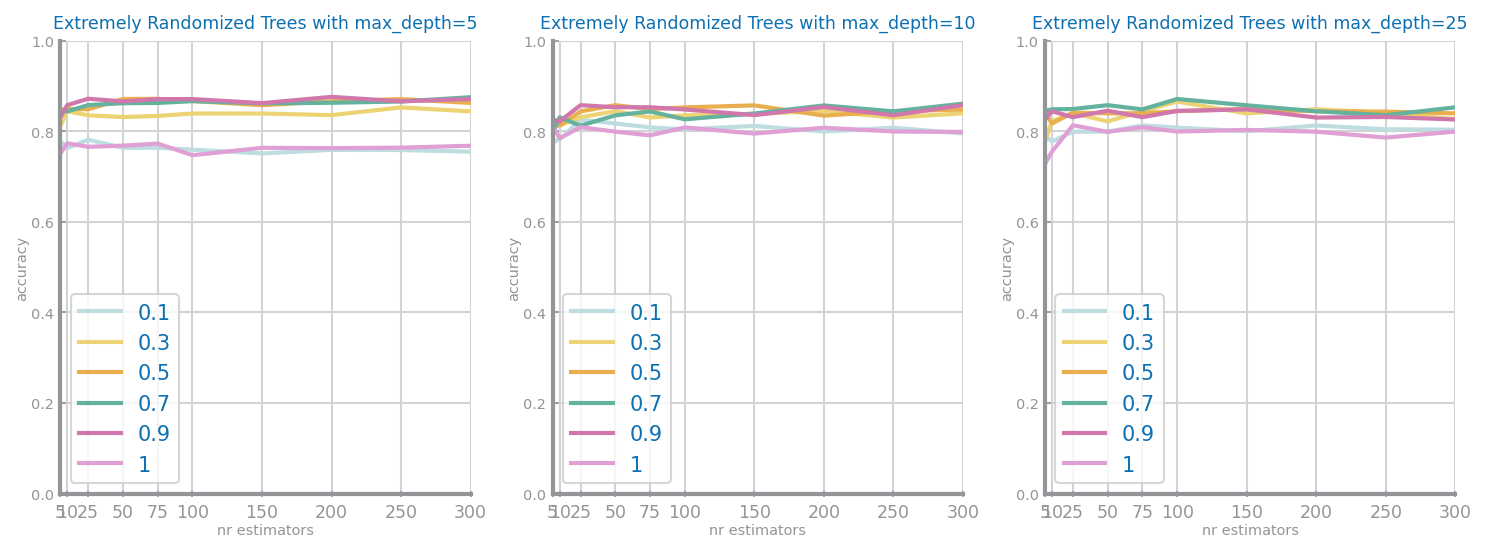

Best results with depth=5, 0.90 features and 200 estimators, with accuracy=0.88


In [19]:
best_extr_tree = ('', 0, 0)
last_best_xt = 0
best_xt = None

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        yvalues = []
        for n in n_estimators:
            rf = ExtraTreesClassifier(n_estimators=n, max_depth=d, max_features=f)
          
            yvalues.append(cross_val_score(rf, X, y, cv=kf).mean())
            
            if yvalues[-1] > last_best_xt:
                best_extr_tree = (d, f, n)
                last_best_xt = yvalues[-1]
                best_xt = rf

        values[f] = yvalues
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Extremely Randomized Trees with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)

plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best_extr_tree[0], best_extr_tree[1], best_extr_tree[2], last_best_xt))

### Comparing Results

In [20]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(n_estimators=best_rand_forest[2], max_depth=best_rand_forest[0], max_features=best_rand_forest[1])
    rf.fit(trnX, trnY)
    
    prd_trn = rf.predict(trnX)
    prd_tst = rf.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx_rt = np.mean(matrices, axis=2).astype('int64')

evaluation_rt = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

Random Forests:
 {'Accuracy': array([1.  , 0.87]), 'Recall': array([1.  , 0.65]), 'Specificity': array([1.  , 0.95]), 'Precision': array([1.  , 0.82])}

Extremely Random Trees:
 {'Accuracy': array([0.94, 0.87]), 'Recall': array([0.83, 0.66]), 'Specificity': array([0.98, 0.95]), 'Precision': array([0.95, 0.85])}


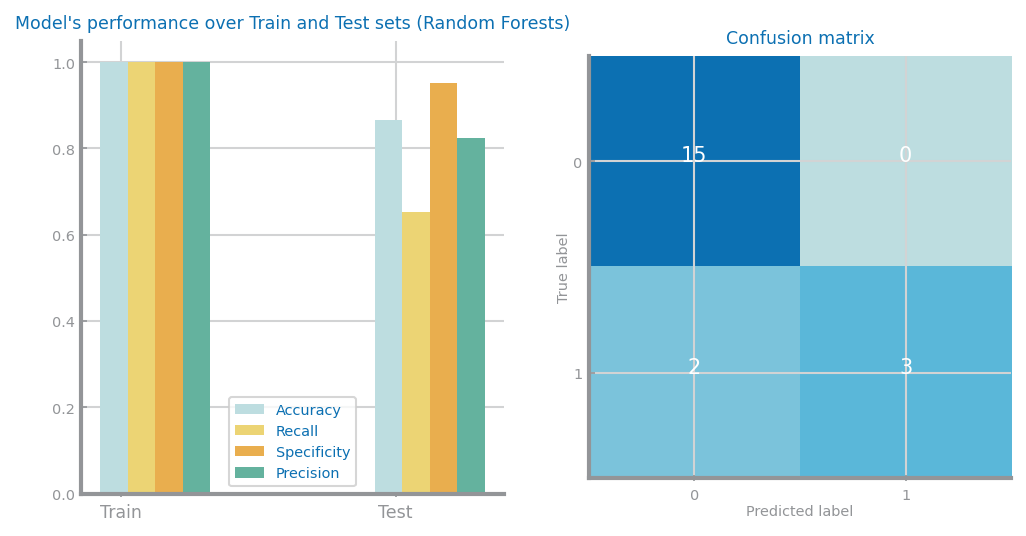

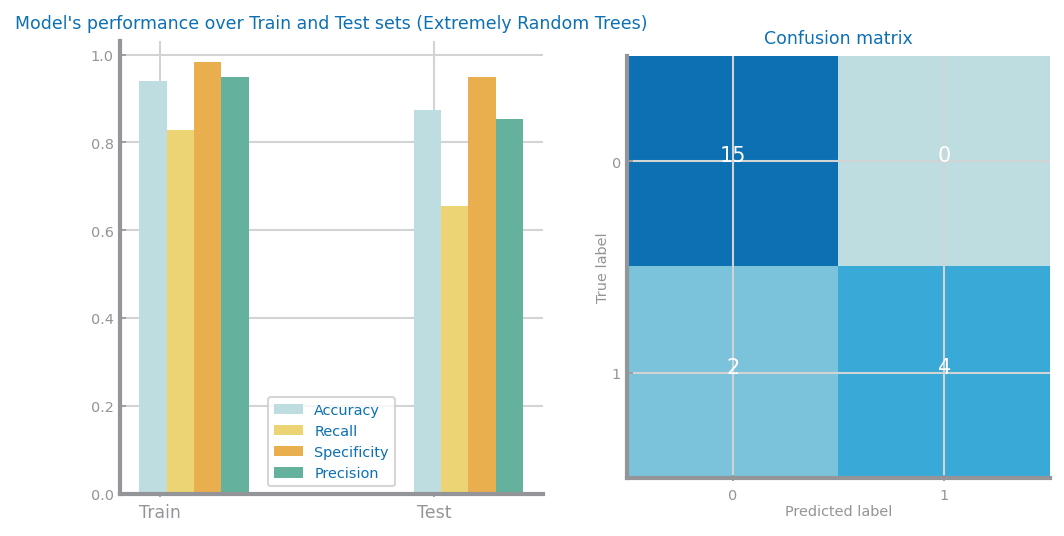

In [21]:
acc = [0, 0]
recall = [0, 0]
specificity = [0, 0]
precision = [0, 0]
matrices = np.zeros((2, 2, N_SPLITS))
h = 0

for train_index, test_index in kf.split(X):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    
    et = ExtraTreesClassifier(n_estimators=best_extr_tree[2], max_depth=best_extr_tree[0], max_features=best_extr_tree[1])
    et.fit(trnX, trnY)
    
    prd_trn = et.predict(trnX)
    prd_tst = et.predict(tstX)
    
    cnf_mtx_trn = metrics.confusion_matrix(trnY, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tstY, prd_tst, labels)
    matrices[:,:,h] = cnf_mtx_tst
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()
    
    acc[0] += (tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn)
    acc[1] += (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)
    
    recall[0] += tp_trn / (tp_trn + fn_trn)
    recall[1] += tp_tst / (tp_tst + fn_tst)
    
    specificity[0] += tn_trn / (tn_trn + fp_trn)
    specificity[1] += tn_tst / (tn_tst + fp_tst)
    
    precision[0] += tp_trn / (tp_trn + fp_trn)
    precision[1] += tp_tst / (tp_tst + fp_tst)
    
    h += 1
    
acc = np.divide(acc, N_SPLITS)
recall = np.divide(recall, N_SPLITS)
specificity = np.divide(specificity, N_SPLITS)
precision = np.divide(precision, N_SPLITS)
cnf_mtx = np.mean(matrices, axis=2).astype('int64')

evaluation = {'Accuracy': acc,
              'Recall': recall,
              'Specificity': specificity,
              'Precision': precision}

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation_rt, ax=axs[0], title="Model's performance over Train and Test sets (Random Forests)")
ds.plot_confusion_matrix(cnf_mtx_rt, labels, ax=axs[1])

print("Random Forests:\n", evaluation_rt)

fig, axs = plt.subplots(1, 2, figsize=(2 * ds.HEIGHT, ds.HEIGHT))
ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets (Extremely Random Trees)")
ds.plot_confusion_matrix(cnf_mtx, labels, ax=axs[1])

print("\nExtremely Random Trees:\n", evaluation)